In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from datetime import datetime

df = pd.read_csv("fraudTest.csv")
print("Original data shape:", df.shape)

df = df.drop_duplicates()
print("Data shape after dropping duplicates:", df.shape)

df["dob"] = pd.to_datetime(df["dob"], errors="coerce")
df["age"] = df["dob"].apply(lambda x: datetime.now().year - x.year if pd.notnull(x) else np.nan)

df = df.drop(["trans_date_trans_time", "cc_num", "merchant", "dob", "trans_num", "unix_time"], axis=1)

imputer = SimpleImputer(strategy="most_frequent")
df[df.columns] = imputer.fit_transform(df)
print("Data shape after imputing missing values:", df.shape) 

categorical_features = ["category", "gender", "job"]
numerical_features = ["amt", "city_pop", "lat", "long", "merch_lat", "merch_long", "age"]
target = "is_fraud"

df[target] = df[target].astype(int) 
print("Unique values in target column:", df[target].unique())  
print("Data shape after processing target column:", df.shape) 

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_features)
    ]
)

X = df[numerical_features + categorical_features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

feature_names = preprocessor.get_feature_names_out()
X_train_transformed = pd.DataFrame(X_train_transformed, columns=feature_names)
X_test_transformed = pd.DataFrame(X_test_transformed, columns=feature_names)

print("Training data shape:", X_train_transformed.shape, y_train.shape)
print("Test data shape:", X_test_transformed.shape, y_test.shape)


Original data shape: (555719, 23)
Data shape after dropping duplicates: (555719, 23)
Data shape after imputing missing values: (555719, 18)
Unique values in target column: [0 1]
Data shape after processing target column: (555719, 18)
Training data shape: (444575, 501) (444575,)
Test data shape: (111144, 501) (111144,)


In [2]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

log_reg_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000, random_state=42))
])

log_reg_pipeline.fit(X_train, y_train)
log_reg_pipeline
print("Logistic Regression Accuracy:", log_reg_pipeline.score(X_test, y_test))

Logistic Regression Accuracy: 0.9958432304038005


In [3]:
log_reg_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['amt', 'city_pop', 'lat',
                                                   'long', 'merch_lat',
                                                   'merch_long', 'age']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['category', 'gender',
                                                   'job'])])),
                ('classifier',
                 LogisticRegression(max_iter=1000, random_state=42))])

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

rf_pipeline = Pipeline([
    ("preprocessor", preprocessor),  
    ("classifier", RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1))
])

rf_pipeline.fit(X_train, y_train)

rf_pipeline

print("Random Forest Accuracy:", rf_pipeline.score(X_test, y_test))  

Random Forest Accuracy: 0.9961671345281796


In [5]:
rf_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['amt', 'city_pop', 'lat',
                                                   'long', 'merch_lat',
                                                   'merch_long', 'age']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['category', 'gender',
                                                   'job'])])),
                ('classifier',
                 RandomForestClassifier(max_depth=10, n_jobs=-1,
                                        random_state=42))])

In [6]:
from xgboost import XGBClassifier

xgb_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", XGBClassifier(n_estimators=50, max_depth=7, tree_method="hist", learning_rate=0.1, n_jobs=-1, random_state=42))
])

xgb_pipeline.fit(X_train, y_train)
print("XGBoost Accuracy:", xgb_pipeline.score(X_test, y_test))

XGBoost Accuracy: 0.9978046498236522


In [7]:
xgb_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['amt', 'city_pop', 'lat',
                                                   'long', 'merch_lat',
                                                   'merch_long', 'age']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['category', 'gender',
                                                   'job'])])),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsa...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=7, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=50, n_jobs=-1,
                               num_parallel_tree=None, random_state=42, ...))])

In [ ]:
import os
os.environ["JOBLIB_MULTIPROCESSING"] = "0"
os.environ["JOBLIB_TEMP_FOLDER"] = "./tmp"

In [ ]:
print(log_reg_pipeline.predict(X_test)[:5])
print(rf_pipeline.predict(X_test)[:5])
print(xgb_pipeline.predict(X_test)[:5])

[0 0 0 0 0]
[0 0 0 0 0]
[0 0 0 0 0]


In [8]:
from sklearn.metrics import accuracy_score

In [9]:
from sklearn.ensemble import VotingClassifier

ensemble_model = VotingClassifier(estimators=[
    ('lr', log_reg_pipeline),  
    ('rf', rf_pipeline),  
    ('xgb', xgb_pipeline)  
], voting='soft', n_jobs=1) 

ensemble_model.fit(X_train, y_train)
y_pred_ensemble = ensemble_model.predict(X_test)
ensemble_model
print("Ensemble Model Accuracy:", accuracy_score(y_test, y_pred_ensemble))

Ensemble Model Accuracy: 0.9961941265385446


In [10]:
ensemble_model

VotingClassifier(estimators=[('lr',
                              Pipeline(steps=[('preprocessor',
                                               ColumnTransformer(transformers=[('num',
                                                                                StandardScaler(),
                                                                                ['amt',
                                                                                 'city_pop',
                                                                                 'lat',
                                                                                 'long',
                                                                                 'merch_lat',
                                                                                 'merch_long',
                                                                                 'age']),
                                                                               ('cat',
                                                                                OneHotEncoder(handle_unknown='ignore',
                                                                                              sparse_output=False),
                                                                                ['category',
                                                                                 'gender',
                                                                                 'job'])])),
                                              ('classifier',
                                               LogisticRegression(max_iter=1000,
                                                                  random_state=42))]...
                                                             importance_type=None,
                                                             interaction_constraints=None,
                                                             learning_rate=0.1,
                                                             max_bin=None,
                                                             max_cat_threshold=None,
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=7,
                                                             max_leaves=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=50,
                                                             n_jobs=-1,
                                                             num_parallel_tree=None,
                                                             random_state=42, ...))]))],
                 n_jobs=1, voting='soft')

In [12]:
from sklearn.metrics import confusion_matrix

In [13]:
y_pred = ensemble_model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[110718      0]
 [   423      3]]


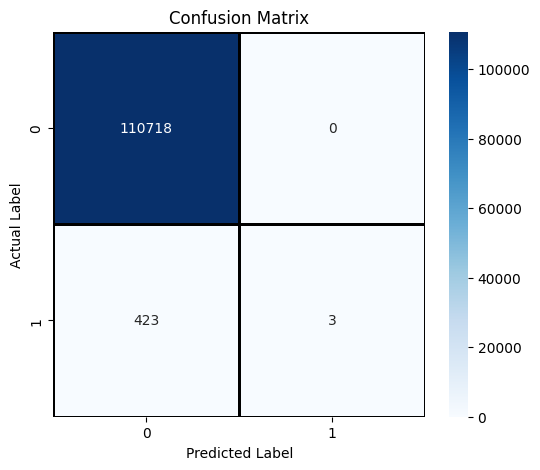

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_pred = ensemble_model.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", linewidths=1, linecolor="black")

plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix")

plt.show()


C:\Users\srees\AppData\Local\Temp\ipykernel_10552\566538749.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fraud_risk = df.groupby('amount_group')['is_fraud'].mean() * 100


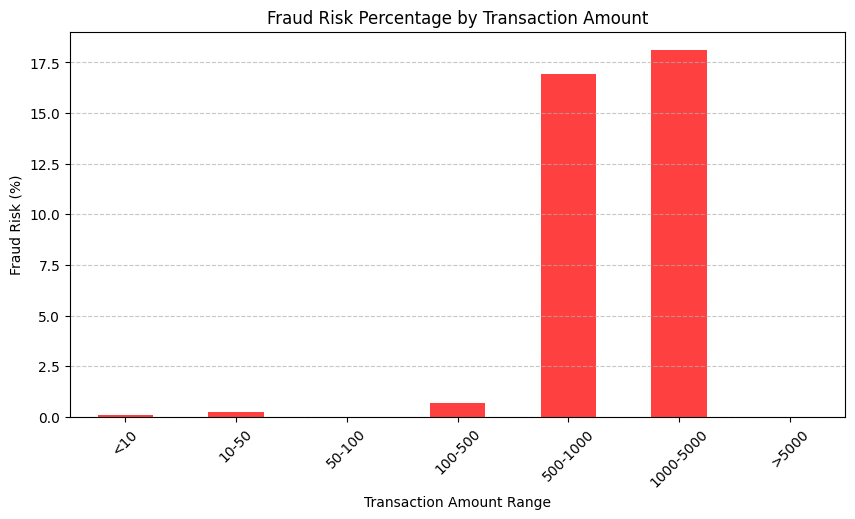

In [15]:
import matplotlib.pyplot as plt
import numpy as np

bins = [0, 10, 50, 100, 500, 1000, 5000, np.inf]
labels = ['<10', '10-50', '50-100', '100-500', '500-1000', '1000-5000', '>5000']

df['amount_group'] = pd.cut(df['amt'], bins=bins, labels=labels)

fraud_risk = df.groupby('amount_group')['is_fraud'].mean() * 100  

plt.figure(figsize=(10, 5))
fraud_risk.plot(kind='bar', color='red', alpha=0.75)
plt.xlabel("Transaction Amount Range")
plt.ylabel("Fraud Risk (%)")
plt.title("Fraud Risk Percentage by Transaction Amount")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

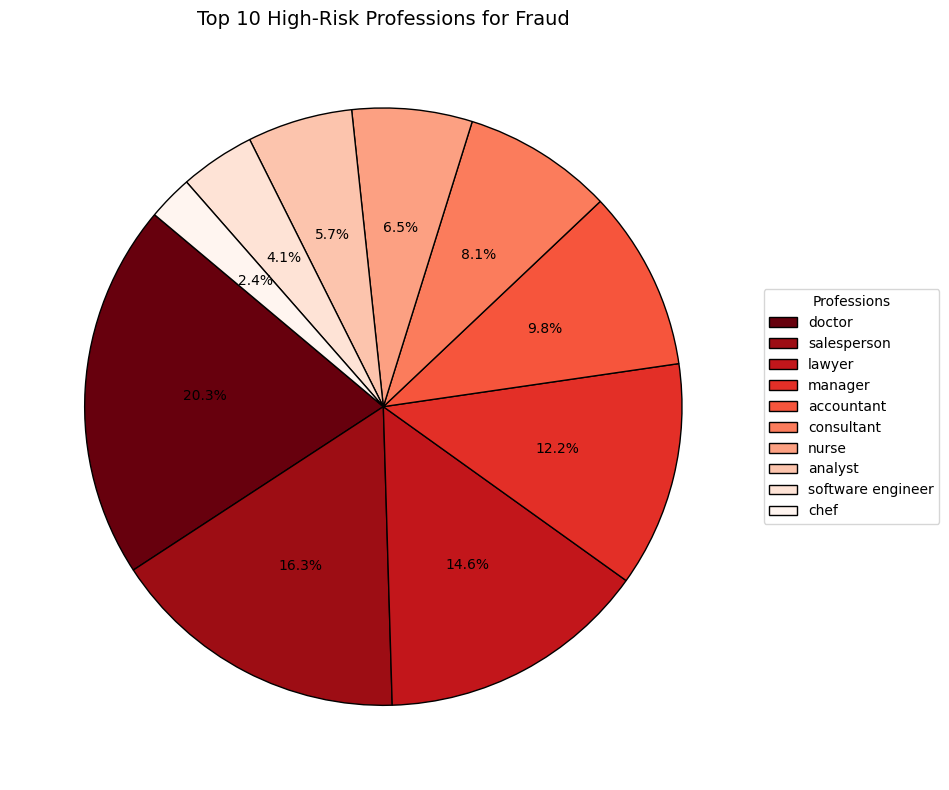

In [19]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

data = {
    'job': ['doctor', 'software engineer', 'lawyer', 'teacher', 'nurse', 'accountant', 'salesperson', 'manager', 'consultant', 'analyst', 'chef', 'artist'],
    'is_fraud': [0.25, 0.05, 0.18, 0.02, 0.08, 0.12, 0.20, 0.15, 0.10, 0.07, 0.03, 0.01]
}
df = pd.DataFrame(data)

profession_fraud_risk = df.groupby('job')['is_fraud'].mean().sort_values(ascending=False) * 100

top_10_professions = profession_fraud_risk.head(10)

plt.figure(figsize=(12, 8))

wedges, texts, autotexts = plt.pie(top_10_professions, autopct='%1.1f%%', 
                                    colors=plt.cm.Reds_r(np.linspace(0, 1, 10)), startangle=140, 
                                    wedgeprops={'edgecolor': 'black'},
                                    textprops={'fontsize': 10})

plt.title("Top 10 High-Risk Professions for Fraud", fontsize=14)

plt.legend(wedges, top_10_professions.index,
          title="Professions",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.tight_layout()
plt.subplots_adjust(right=0.75)

plt.show()

C:\Users\srees\AppData\Local\Temp\ipykernel_10552\941950908.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fraud_counts.index, y=fraud_counts.values, palette="viridis")


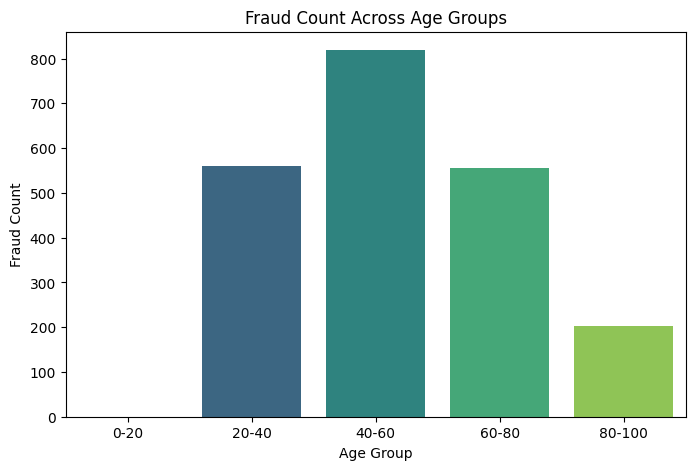

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

age_bins = [0, 20, 40, 60, 80, 100]
age_labels = ["0-20", "20-40", "40-60", "60-80", "80-100"]

df["age_group"] = pd.cut(df["age"], bins=age_bins, labels=age_labels, right=False)

fraud_counts = df[df["is_fraud"] == 1]["age_group"].value_counts().sort_index()

plt.figure(figsize=(8, 5))
sns.barplot(x=fraud_counts.index, y=fraud_counts.values, palette="viridis")

plt.xlabel("Age Group")
plt.ylabel("Fraud Count")
plt.title("Fraud Count Across Age Groups")
plt.show()

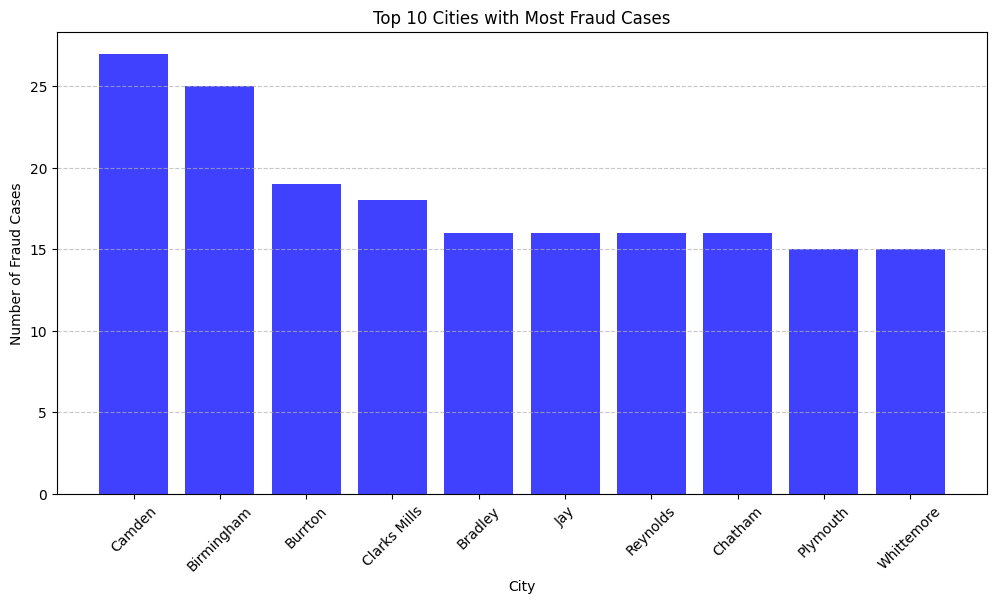

In [18]:
import matplotlib.pyplot as plt

fraud_data = df[df['is_fraud'] == 1]

city_fraud_count = fraud_data['city'].value_counts().head(10)

plt.figure(figsize=(12, 6))
plt.bar(city_fraud_count.index, city_fraud_count.values, color='blue', alpha=0.75)
plt.xlabel("City")
plt.ylabel("Number of Fraud Cases")
plt.title("Top 10 Cities with Most Fraud Cases")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
